<a href="https://colab.research.google.com/github/farenga/neuralODE/blob/main/2_Lotka_Volterra_Spiral_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spiral Lotka-Volterra

Equations:

$$
\begin{cases}    
\dot{u_1}(t) = u_1(t)(\mu-0.1u_1(t)-0.5u_2(t)-0.5u_3(t))\\
\dot{u_2}(t) = u_2(t)(-\mu+0.5u_1(t)-0.3u_3(t))\\
\dot{u_3}(t) = u_3(t)(-\mu+0.2u_1(t)+0.5u_2(t))\\
u_i(0) = 0.5 \quad\end{cases} \qquad\mu = 1.95
$$

so since $\mathbf{f}(u(t),t,\theta)$

In [78]:
!pip install torchdiffeq

In [79]:
import os
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

In [129]:
method = 'dopr15'
data_size = 200
batch_time = 100
batch_size = 50
niters = 5000
test_freq = 100
gpu = 0
viz = True
adjoint = False
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [130]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [141]:
true_u0 = torch.tensor([[.5, .5, .5]]).to(device)
t = torch.linspace(0., 10., data_size).to(device)

In [83]:
mu = 1.95

In [84]:
class Lambda(nn.Module):

    def forward(self, t, u):
      u1 = u[0][0]
      u2 = u[0][1]
      u3 = u[0][2]
      return torch.tensor([ 
                            [ u1*(mu - .1*u1 - .5*u2 - .5*u3) ],
                            [ u2*(-mu + .5*u1 - .3*u3) ],
                            [ u3*(-mu + .2*u1 + .5*u2) ]
                             
                             ]).reshape([1,3]).to(device)


In [85]:
with torch.no_grad():
    true_u = odeint(Lambda(), true_u0, t, method='dopri5') # [time,state] = [t,u(t)]

In [ ]:
fig = plt.figure(figsize=(20, 6), facecolor='white')
ax_phase_1_true = fig.add_subplot(131, frameon=False)
ax_phase_1_true.plot(true_u[:, :, 0], true_u[:, :, 1], 'g-')
ax_phase_2_true = fig.add_subplot(132, frameon=False)
ax_phase_2_true.plot(true_u[:, :, 0], true_u[:, :, 2], 'g-')
ax_phase_3_true = fig.add_subplot(133, frameon=False)
ax_phase_3_true.plot(true_u[:, :, 1], true_u[:, :, 2], 'g-')

In [87]:
def get_batch():
    # generate a tensor of N=batch_size random indices in the range(0,data_size-batch_time) -> 100-10 = 90
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_u[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_u[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)


In [88]:
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [ ]:
if viz:
    makedirs('png')
    fig = plt.figure(figsize=(20, 6), facecolor='white')
#   ax_traj = fig.add_subplot(131, frameon=False)
    ax_phase_1 = fig.add_subplot(131, frameon=False)
    ax_phase_2 = fig.add_subplot(132, frameon=False)
    ax_phase_3 = fig.add_subplot(133, frameon=False)
#   ax_vecfield = fig.add_subplot(133, frameon=False)
    plt.show(block=False)

In [90]:
plot_x_lim = 3
plot_y_lim = 3

def visualize(true_u, pred_u, odefunc, itr, batch_y, batch_t):

    if viz:

        ax_phase_1.cla()
        ax_phase_1.set_title('Phase Portrait, Species 1-2')
        ax_phase_1.set_xlabel('x1')
        ax_phase_1.set_ylabel('x2')
        ax_phase_1.plot(true_u.cpu().numpy()[:, 0, 0], true_u.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase_1.plot(pred_u.cpu().numpy()[:, 0, 0], pred_u.cpu().numpy()[:, 0, 1], 'b--')
        ax_phase_1.plot(batch_u0.cpu().numpy()[:, 0, 0], batch_u0.cpu().numpy()[:, 0, 1], 'r*')
        #ax_phase_1.set_xlim(0, plot_x_lim)
        #ax_phase_1.set_ylim(0, plot_y_lim)
        
        ax_phase_2.cla()
        ax_phase_2.set_title('Phase Portrait, Species 1-3')
        ax_phase_2.set_xlabel('x1')
        ax_phase_2.set_ylabel('x3')
        ax_phase_2.plot(true_u.cpu().numpy()[:, 0, 0], true_u.cpu().numpy()[:, 0, 2], 'g-')
        ax_phase_2.plot(pred_u.cpu().numpy()[:, 0, 0], pred_u.cpu().numpy()[:, 0, 2], 'b--')
        ax_phase_2.plot(batch_u0.cpu().numpy()[:, 0, 0], batch_u0.cpu().numpy()[:, 0, 2], 'r*')
        #ax_phase_2.set_xlim(0, plot_x_lim)
        #ax_phase_2.set_ylim(0, plot_y_lim)

        ax_phase_3.cla()
        ax_phase_3.set_title('Phase Portrait, Species 2-3')
        ax_phase_3.set_xlabel('x2')
        ax_phase_3.set_ylabel('x3')
        ax_phase_3.plot(true_u.cpu().numpy()[:, 0, 1], true_u.cpu().numpy()[:, 0, 2], 'g-')
        ax_phase_3.plot(pred_u.cpu().numpy()[:, 0, 1], pred_u.cpu().numpy()[:, 0, 2], 'b--')
        ax_phase_3.plot(batch_u0.cpu().numpy()[:, 0, 1], batch_u0.cpu().numpy()[:, 0, 2], 'r*')
        #ax_phase_3.set_xlim(0, plot_x_lim)
        #ax_phase_3.set_ylim(0, plot_y_lim)

        
        fig.tight_layout()
        fig.savefig('png/{:03d}'.format(itr))
        fig.show()
        #plt.draw()
        #plt.pause(0.001)

In [91]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 50),
            nn.Tanh(),
            nn.Linear(50, 3)
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [92]:
def lr_schedule(loss):
  if(loss < .7):
    return 1e-5
  if(loss < 1):
    return 1e-4
  else:
    return 1e-3

In [93]:
batch_u0, batch_t, batch_u = get_batch()
batch_t

tensor([0.0000, 0.0503, 0.1005, 0.1508, 0.2010, 0.2513, 0.3015, 0.3518, 0.4020,
        0.4523, 0.5025, 0.5528, 0.6030, 0.6533, 0.7035, 0.7538, 0.8040, 0.8543,
        0.9045, 0.9548, 1.0050, 1.0553, 1.1055, 1.1558, 1.2060, 1.2563, 1.3065,
        1.3568, 1.4070, 1.4573, 1.5075, 1.5578, 1.6080, 1.6583, 1.7085, 1.7588,
        1.8090, 1.8593, 1.9095, 1.9598, 2.0101, 2.0603, 2.1106, 2.1608, 2.2111,
        2.2613, 2.3116, 2.3618, 2.4121, 2.4623, 2.5126, 2.5628, 2.6131, 2.6633,
        2.7136, 2.7638, 2.8141, 2.8643, 2.9146, 2.9648, 3.0151, 3.0653, 3.1156,
        3.1658, 3.2161, 3.2663, 3.3166, 3.3668, 3.4171, 3.4673, 3.5176, 3.5678,
        3.6181, 3.6683, 3.7186, 3.7688, 3.8191, 3.8693, 3.9196, 3.9698, 4.0201,
        4.0704, 4.1206, 4.1709, 4.2211, 4.2714, 4.3216, 4.3719, 4.4221, 4.4724,
        4.5226, 4.5729, 4.6231, 4.6734, 4.7236, 4.7739, 4.8241, 4.8744, 4.9246,
        4.9749])

## Training

In [94]:
n = 10
ensemble = []
for j in range(n):
  ensemble.append(ODEFunc().to(device))


In [95]:
ensemble[0]

ODEFunc(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=3, bias=True)
  )
)

In [96]:
ii = 0


for i,func in enumerate(ensemble):

  print("Model #"+str(i))

  optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,  verbose=False)

  loss_array = []
  itr_time = []

#  start = time.time()
  for itr in range(1, niters + 1):
      
#      start_itr = time.time()

      optimizer.zero_grad()
      
      batch_u0, batch_t, batch_u = get_batch()
      pred_u = odeint(func, batch_u0, batch_t).to(device)
      
      loss = torch.mean(torch.abs(pred_u - batch_u))
      
      loss.backward()
      optimizer.step()
      #scheduler.step(loss)
      
 #     itr_time.append(time.time()-start_itr)
      
      if itr % test_freq == 0:
        with torch.no_grad():
       #       pred_u = odeint(func, true_u0, t)
       #       loss = torch.mean(torch.abs(pred_u - true_u))
               loss_array.append(loss.item())
               print('Iter ' + str(itr)+'/'+str(niters) + '  |  Loss: ' + str(round(loss.item(),6)) + '  |  lr: ' + str(optimizer.param_groups[0]['lr']))
       #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
       #       ii += 1

#total_elapsed_time = time.time()-start

Model #0
Iter 100/5000  |  Loss: 1.469048  |  lr: 0.001
Iter 200/5000  |  Loss: 1.250463  |  lr: 0.001
Iter 300/5000  |  Loss: 0.957808  |  lr: 0.001
Iter 400/5000  |  Loss: 0.760436  |  lr: 0.001
Iter 500/5000  |  Loss: 0.693915  |  lr: 0.001
Iter 600/5000  |  Loss: 0.672539  |  lr: 0.001
Iter 700/5000  |  Loss: 0.579987  |  lr: 0.001
Iter 800/5000  |  Loss: 0.564294  |  lr: 0.001
Iter 900/5000  |  Loss: 0.501393  |  lr: 0.001
Iter 1000/5000  |  Loss: 0.488979  |  lr: 0.001
Iter 1100/5000  |  Loss: 0.519321  |  lr: 0.001
Iter 1200/5000  |  Loss: 0.477267  |  lr: 0.001
Iter 1300/5000  |  Loss: 0.486162  |  lr: 0.001
Iter 1400/5000  |  Loss: 0.432071  |  lr: 0.001
Iter 1500/5000  |  Loss: 0.435059  |  lr: 0.001
Iter 1600/5000  |  Loss: 0.38772  |  lr: 0.001
Iter 1700/5000  |  Loss: 0.414008  |  lr: 0.001
Iter 1800/5000  |  Loss: 0.404208  |  lr: 0.001
Iter 1900/5000  |  Loss: 0.370184  |  lr: 0.001
Iter 2000/5000  |  Loss: 0.350891  |  lr: 0.001
Iter 2100/5000  |  Loss: 0.3305  |  lr: 0

## Extrapolation

In [97]:
true_u0 = torch.tensor([[.5, .5, .5]]).to(device)
t_train = t[:batch_time]
t_test = t[batch_time:]
t = t

with torch.no_grad():
    true_u = odeint(Lambda(), true_u0, t_train, method='dopri5') # [time,state] = [t,u(t)]
    true_u_test = odeint(Lambda(), true_u[-1], t_test, method='dopri5') # [time,state] = [t,u(t)]

In [98]:
pred = []
for func in ensemble:
  pred.append(odeint(func, true_u0, t).to(device))

In [99]:
pred_tensor = torch.stack(pred)

In [172]:
with torch.no_grad():
  mean_pred = torch.mean(pred_tensor,0)

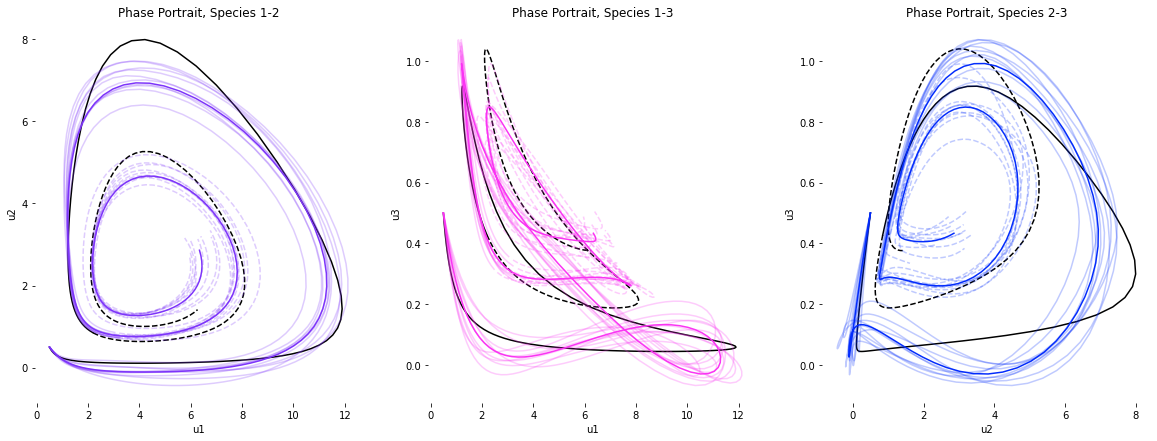

In [173]:
fig = plt.figure(figsize=(20, 7), facecolor='white')

colors = ['#7d34fa','#fa34f3','#032cfc','#ff006f','#00ffd5','#62ff57']
gtc = '#000000'
ax_phase_1_test = fig.add_subplot(131, frameon=False)
ax_phase_1_test.set_title('Phase Portrait, Species 1-2')
ax_phase_1_test.set_xlabel('u1')
ax_phase_1_test.set_ylabel('u2')
ax_phase_1_test.plot(true_u[:, :, 0], true_u[:, :, 1], '-', color=gtc)
ax_phase_1_test.plot(true_u_test[:, :, 0], true_u_test[:, :, 1], '--', color=gtc)
ax_phase_1_test.plot(mean_pred[:, :, 0], mean_pred[:, :, 1], '-', color=colors[0])


ax_phase_2_test = fig.add_subplot(132, frameon=False)
ax_phase_2_test.set_title('Phase Portrait, Species 1-3')
ax_phase_2_test.set_xlabel('u1')
ax_phase_2_test.set_ylabel('u3')
ax_phase_2_test.plot(true_u[:, :, 0], true_u[:, :, 2], '-', color=gtc)
ax_phase_2_test.plot(true_u_test[:, :, 0], true_u_test[:, :, 2], '--', color=gtc)
ax_phase_2_test.plot(mean_pred[:, :, 0], mean_pred[:, :, 2], '-', color=colors[1])


ax_phase_3_test = fig.add_subplot(133, frameon=False)
ax_phase_3_test.set_title('Phase Portrait, Species 2-3')
ax_phase_3_test.set_xlabel('u2')
ax_phase_3_test.set_ylabel('u3')
ax_phase_3_test.plot(true_u[:, :, 1], true_u[:, :, 2], '-', color=gtc)
ax_phase_3_test.plot(true_u_test[:, :, 1], true_u_test[:, :, 2], '--', color=gtc)
ax_phase_3_test.plot(mean_pred[:, :, 1], mean_pred[:, :, 2], '-', color=colors[2])

a=.25
for pred_u in pred:
  ax_phase_1_test.plot(pred_u.detach().numpy()[:len(t_train), :, 0], pred_u.detach().numpy()[:len(t_train), :, 1], '-', color=colors[0],alpha=a)
  ax_phase_1_test.plot(pred_u.detach().numpy()[len(t_train):, :, 0], pred_u.detach().numpy()[len(t_train):, :, 1], '--', color=colors[0],alpha=a)
  ax_phase_2_test.plot(pred_u.detach().numpy()[:len(t_train), :, 0], pred_u.detach().numpy()[:len(t_train), :, 2], '-', color=colors[1],alpha=a)
  ax_phase_2_test.plot(pred_u.detach().numpy()[len(t_train):, :, 0], pred_u.detach().numpy()[len(t_train):, :, 2], '--',  color=colors[1],alpha=a)
  ax_phase_3_test.plot(pred_u.detach().numpy()[:len(t_train), :, 1], pred_u.detach().numpy()[:len(t_train), :, 2], '-',  color=colors[2],alpha=a)
  ax_phase_3_test.plot(pred_u.detach().numpy()[len(t_train):, :, 1], pred_u.detach().numpy()[len(t_train):, :, 2], '--',  color=colors[2],alpha=a)


In [140]:
def ensemble_pred(ensemble, u0, t):
  pred = []
  for func in ensemble:
    pred.append(odeint(func, u0, t).to(device))
    pred_tensor = torch.stack(pred)
    mean_pred = torch.mean(pred_tensor,0)
    std_pred = torch.std(pred_tensor,0)
  return mean_pred,std_pred

In [145]:
mean_pred,std_pred = ensemble_pred(ensemble, true_u0, t)

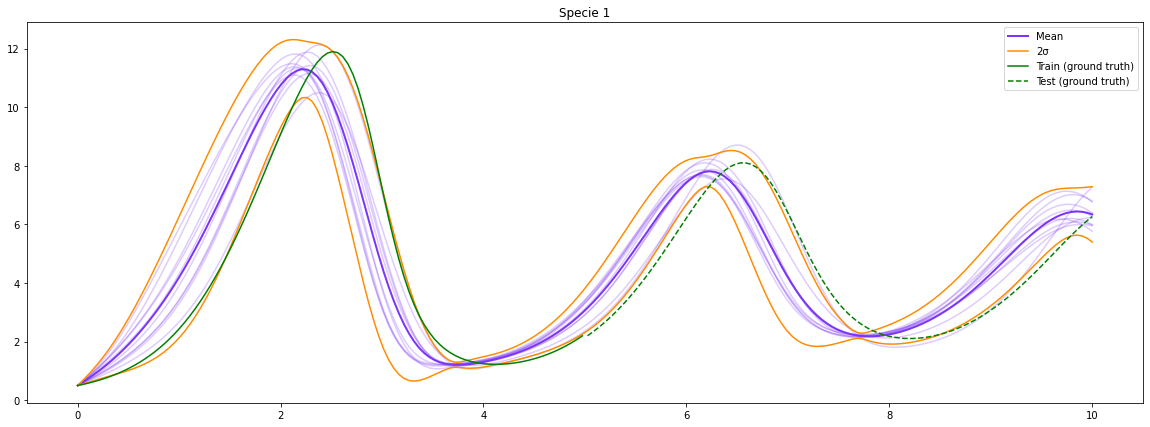

In [174]:

fig = plt.figure(figsize=(20, 7), facecolor='white',frameon=False)

for pred_u in pred:
  plt.plot(t,pred_u[:, :, i].detach().numpy(),color=colors[0],alpha=a)

plt.plot(t,mean_pred[:, :, 0].detach().numpy(),color=colors[0],linewidth=2,label='Mean')
plt.plot(t,mean_pred[:, :, 0].detach().numpy()+2*std_pred[:, :, 0].detach().numpy(),color='darkorange',label='2σ')
plt.plot(t,mean_pred[:, :, 0].detach().numpy()-2*std_pred[:, :, 0].detach().numpy(),color='darkorange')

plt.plot(t_train,true_u[:, :, 0],'-g',label='Train (ground truth)')
plt.plot(t_test,true_u_test[:, :, 0],'--g',label='Test (ground truth)')
plt.title('Specie 1')
plt.legend()

In [143]:
mu,sigma = ensemble_pred(ensemble, true_u0, t)

In [102]:
weights=[]
for w in ensemble[0].parameters():
  weights.append(w.detach().numpy())

Text(0.5, 1.0, 'Layer 2 Weights Distribution')

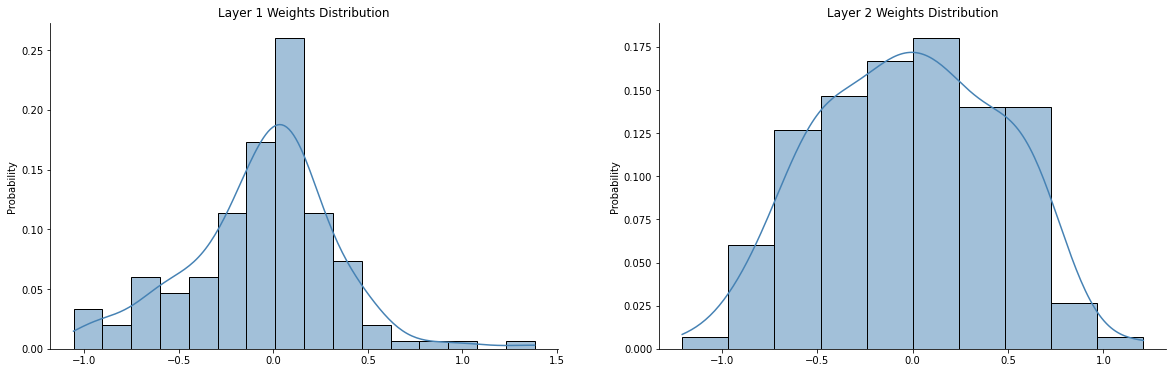

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
sns.despine(fig)

sns.histplot(weights[0].reshape(150),kde=True,stat='probability',color="steelblue", label="Layer 1",ax=axes[0]).set_title('Layer 1 Weights Distribution')
sns.histplot(weights[2].reshape(150),kde=True,stat='probability',color="steelblue", label="Layer 1",ax=axes[1]).set_title('Layer 2 Weights Distribution')